In [1]:
import torch
import numpy as np
from pathlib import Path
import argparse
from neuralop.models import UNO
from magplot.base import create_mesh, mag_plotter
import pyvista as pv
pv.start_xvfb()
pv.set_jupyter_backend('static')

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from rtmag.test.eval_plot import plot_sample

from rtmag.test.eval import evaluate

In [2]:
meta_path = Path("/home/usr/workspace/RTNF2/base_new/pino_CC_Hnorm_Unit_2")
checkpoint = torch.load(meta_path / "best_model.pt", map_location=device)

args = argparse.Namespace()
info = np.load(meta_path / 'args.npy', allow_pickle=True).item()
for key, value in info.items():
        args.__dict__[key] = value

# b_norm = args.data["b_norm"]

model = UNO(
        hidden_channels = args.model["hidden_channels"],
        in_channels = args.model["in_channels"],
        out_channels = args.model["out_channels"],
        lifting_channels = args.model["lifting_channels"],
        projection_channels = args.model["projection_channels"],
        n_layers = args.model["n_layers"],

        factorization = args.model["factorization"],
        implementation = args.model["implementation"],
        rank = args.model["rank"],

        uno_n_modes = args.model["uno_n_modes"], 
        uno_out_channels = args.model["uno_out_channels"],
        uno_scalings = args.model["uno_scalings"],
    ).to(device)

checkpoint = torch.load(meta_path / 'best_model.pt')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [3]:
idx = 239

data_path = Path('/mnt/f/isee_dataset/12673/input/').glob('*.npz')
data_path = sorted(data_path)

label_path = Path('/mnt/f/isee_dataset/12673/label/').glob('*.npz')
label_path = sorted(label_path)

print(data_path[idx].name)
print(label_path[idx].name)

input_12673_20170906_083600.npz
label_12673_20170906_083600.npz


In [4]:
inputs = np.load(data_path[idx])
model_input = torch.from_numpy(inputs['input'])[None, ...]

b_norm = torch.max(torch.abs(model_input)).item()
# [batch_size, 3, 513, 257, 1]
model_input = model_input[:, :, :-1, :-1, :] / b_norm # remove duplicated periodic boundary
model_input = model_input.to(device)
model_input = torch.permute(model_input, (0, 4, 3, 2, 1))

model_output = model(model_input)
# [512, 256, 256, 3]
b = model_output.detach().cpu().numpy().transpose(0, 3, 2, 1, 4)[0]
divi = (b_norm / np.arange(1, b.shape[2] + 1)).reshape(1, 1, -1, 1)
b = b * divi

In [5]:
print(b_norm)

4414.97998046875


In [6]:
B = np.load(label_path[idx])["label"][:, :-1, :-1, :-1]
B = B.transpose(1, 2, 3, 0)
B.shape

(512, 256, 256, 3)

In [7]:
evaluate(b, B)

C_vec     : 0.9451
C_cs      : 0.7696
E_n'      : 0.5453
E_m'      : -0.2868
eps       : 0.9666
CW_sin    : 0.8029
L_f       : 179.3801
L_d       : 91.3238
l2_err    : 0.3301


{'C_vec': 0.9450827255873097,
 'C_cs': 0.7695625489993564,
 "E_n'": 0.5453017766989949,
 "E_m'": -0.28683252834110773,
 'eps': 0.9665829921477257,
 'CW_sin': 0.8028941838705794,
 'L_f': 179.38010429155617,
 'L_d': 91.32381837209435,
 'l2_err': 0.33008004863155505}

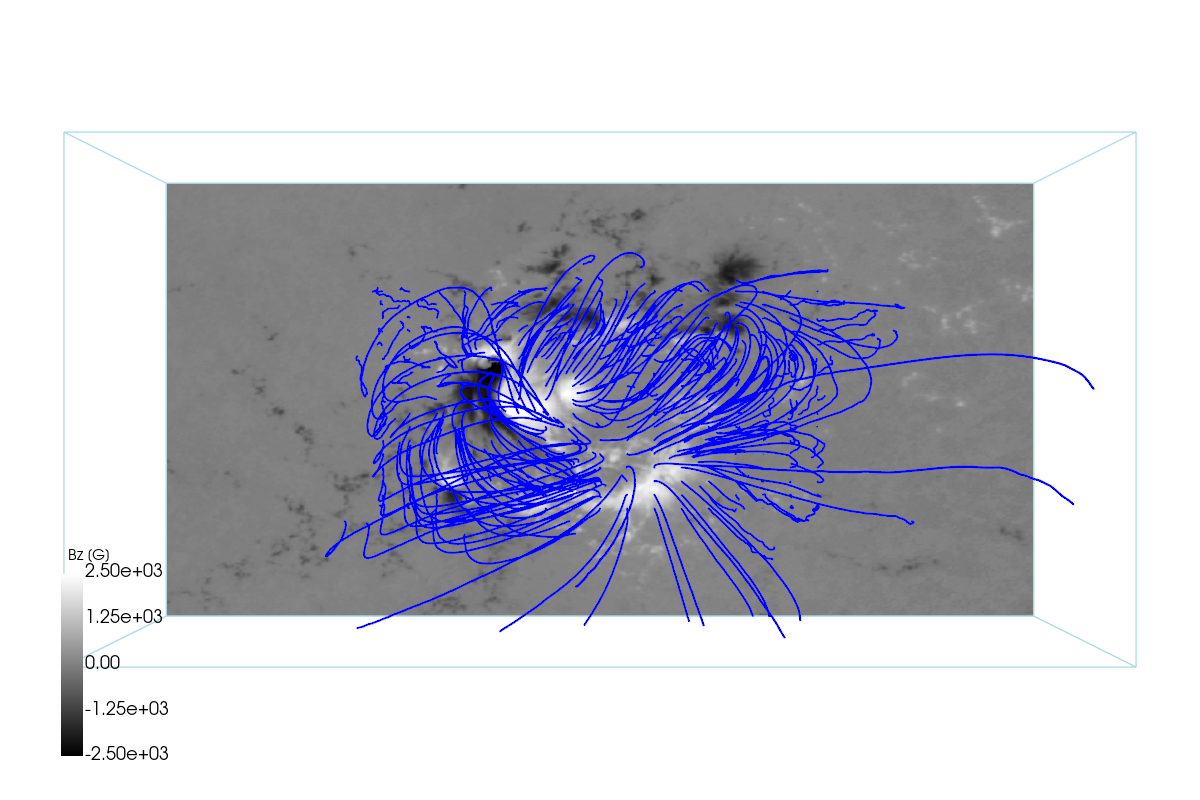

In [8]:
vmin=-2500
vmax=2500
i_siz=b.shape[0] / 2
j_siz=b.shape[1] / 2
i_res=16
j_res=16
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b[..., 0]
by = b[..., 1]
bz = b[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

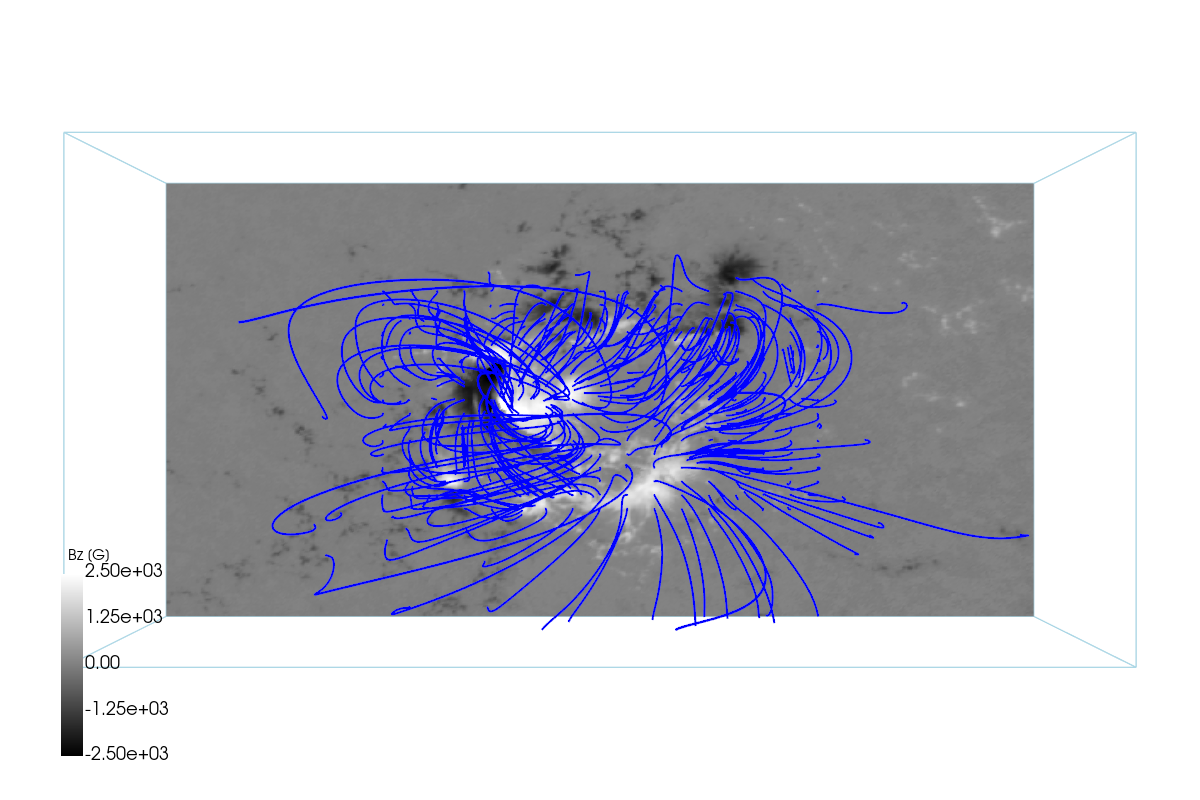

In [9]:
vmin=-2500
vmax=2500
i_siz=B.shape[0] / 2
j_siz=B.shape[1] / 2
i_res=16
j_res=16
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = B[..., 0]
by = B[..., 1]
bz = B[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

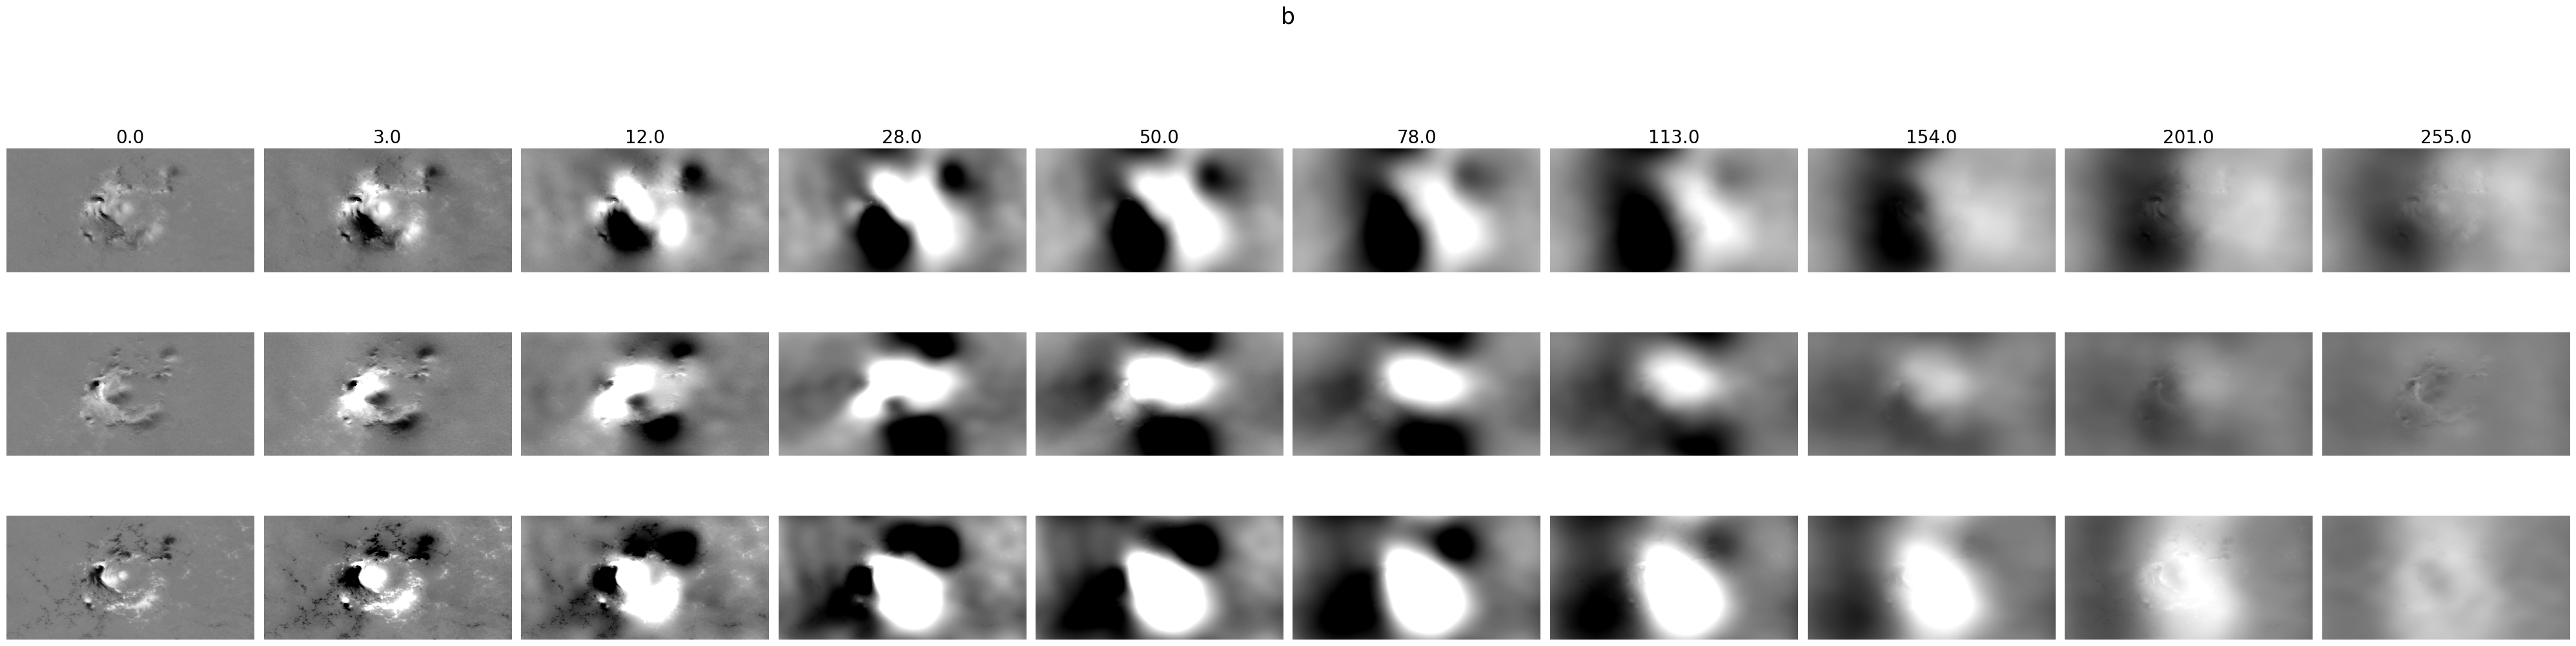

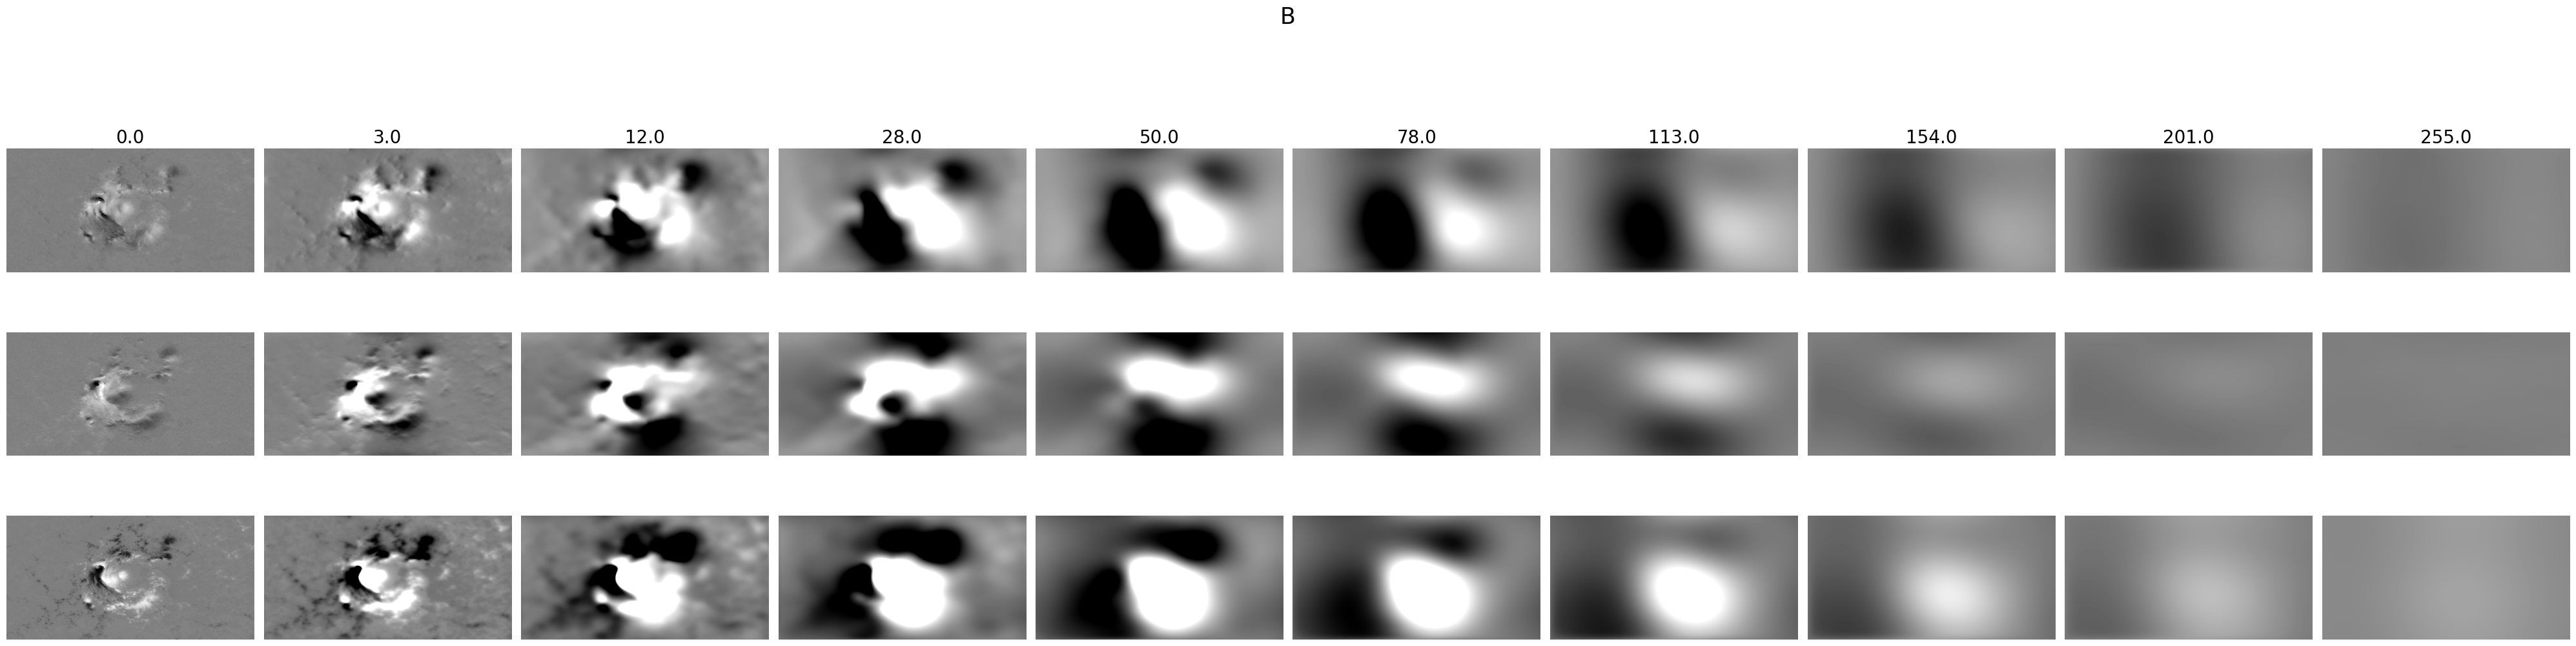

In [10]:
plot_sample(b, B, v_mm=2500)